In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm
from scipy.stats import t

In [2]:
def pdf(x, lam):
    return lam * np.exp(-lam * x) * np.heaviside(x, 1)

def pdf(x, dof):
    return t.pdf(x, dof)

def generate_data(lam, N):
    return np.random.exponential(1./lam, N)

def generate_data(dof, N):
    return np.random.standard_t(dof, N)

In [3]:
from scipy.integrate import simps

def compute_analytic_JSD(dof1, dof2):
    xmin, xmax = -40., 40.
    x_grid = np.linspace(xmin, xmax, 2000000)
    pdf1 = pdf(x_grid, dof1)
    pdf2 = pdf(x_grid, dof2)
    kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
    kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
    return 0.5 * (kl1 + kl2)

def compute_JSD(result1, result2, interpolation='linear', binning="FD"):    
    if binning == "FD":
        number_of_bins_1 = int((result1.max() - result1.min())/(2*iqr(result1)*result1.size**(-1/3)))
    elif binning == "S":
        number_of_bins_1 = int(1 + np.log2(result1.size))
    elif binning == "fuckit50":
        number_of_bins_1 = 50
    if number_of_bins_1 < 5:
        number_of_bins_1 = 5
    nbins1 = np.linspace(result1.min(), result1.max(), number_of_bins_1)
    #nbins1 = np.linspace(0.0, result1.max(), number_of_bins_1)
    if binning == "FD":
        number_of_bins_2 = int((result2.max() - result2.min())/(2*iqr(result2)*result2.size**(-1/3)))
    elif binning == "S":
        number_of_bins_2 = int(1 + np.log2(result2.size))
    elif binning == "fuckit50":
        number_of_bins_2 = 50
    if number_of_bins_2 < 5:
        number_of_bins_2 = 5
    nbins2 = np.linspace(result2.min(), result2.max(), number_of_bins_2)
    #nbins2 = np.linspace(0.0, result2.max(), number_of_bins_2)
    h, bins = np.histogram(
        result1, density=True, bins=nbins1
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])

    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)

    h, bins = np.histogram(
        result2, density=True, bins=nbins2
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    min2, max2 = bin_centres[0], bin_centres[-1]
    fit2 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)
    x_grid = np.linspace(min(min1, min2), max(max1, max2), 10000)
    #x_grid = np.linspace(0.0, max(max1, max2), 1000)

    fit_1t = np.vectorize(fit1)
    fit_2t = np.vectorize(fit2)

    def fit_1(x):
        return max(1e-10, fit1(x))

    def fit_2(x):
        return max(1e-10, fit2(x))


    fit_1 = np.vectorize(fit_1)
    fit_2 = np.vectorize(fit_2)

    # plt.plot(x_grid, fit_1(x_grid))
    # plt.plot(x_grid, fit_2(x_grid))
    # plt.plot(x_grid, fit_1t(x_grid))
    # plt.plot(x_grid, fit_2t(x_grid))
    # plt.hist(result1, bins=nbins1, density=True, alpha=0.5)
    # plt.hist(result2, bins=nbins2, density=True, alpha=0.5)
    # plt.show()

    JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid))**2
    return JSD, fit_1, fit_2

In [5]:
dof1, dof2 = 4, 100
N = 5000
data = generate_data(dof1, N)
data2 = generate_data(dof2, N)
JSD, fit1, fit2 = compute_JSD(data, data2)
print(JSD)
print(compute_analytic_JSD(dof1, dof2))

0.014687594208749346
0.01341667103496343


/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_40028/2219258110.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_40028/2219258110.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)


In [6]:
N_samples = 200
N_points = 15
dof_zero = 4
dof_start = 30
dof_end = 5
dof_factor = (dof_start - dof_end)/(N_points - 1)
dof_list = np.array([dof_start - dof_factor * i for i in range(N_points)])
true_jsds = np.zeros((N_points))
estimated_jsds = np.zeros((N_points, N_samples))
dof_list
for i, variance in tqdm(enumerate(dof_list)):
    true_jsd = compute_analytic_JSD(dof_zero, dof_list[i])
    print(true_jsd, dof_list[i])

0it [00:00, ?it/s]

/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_40028/2219258110.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_40028/2219258110.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
1it [00:00,  2.81it/s]

0.010969295242055093 30.0


2it [00:00,  3.07it/s]

0.01075850236703842 28.214285714285715


3it [00:00,  3.15it/s]

0.010521398794234808 26.428571428571427


4it [00:01,  3.14it/s]

0.010252793883507817 24.642857142857142


5it [00:01,  3.18it/s]

0.009946060765801167 22.857142857142858


6it [00:01,  3.18it/s]

0.009592616728241564 21.07142857142857


7it [00:02,  3.19it/s]

0.009181171059377068 19.285714285714285


8it [00:02,  3.21it/s]

0.0086966200765441 17.5


9it [00:02,  3.21it/s]

0.008118407633020686 15.714285714285714


10it [00:03,  3.23it/s]

0.007418101147231334 13.928571428571427


11it [00:03,  3.24it/s]

0.006555957855004756 12.142857142857142


12it [00:03,  3.24it/s]

0.005476906147473624 10.357142857142858


13it [00:04,  3.26it/s]

0.004110399253051137 8.57142857142857


14it [00:04,  3.28it/s]

0.002401633098515165 6.785714285714285


15it [00:04,  3.22it/s]

0.0005482610582181863 5.0


In [7]:
for i, variance in tqdm(enumerate(dof_list)):
    true_jsd = compute_analytic_JSD(dof_zero, dof_list[i])
    for j in range(N_samples):
        result1 = generate_data(dof_zero, N)
        result2 = generate_data(dof_list[i], N)
        JSD, fit_1, fit_2 = compute_JSD(result1, result2)
        estimated_jsds[i, j] = JSD
    true_jsds[i] = true_jsd

0it [00:00, ?it/s]/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_40028/2219258110.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_40028/2219258110.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
15it [04:16, 17.12s/it]


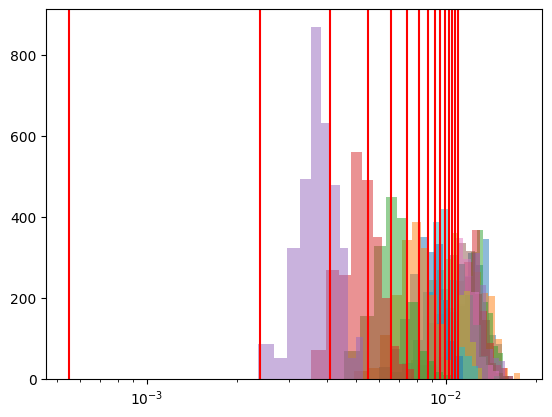

In [8]:
for i in range(N_points):
    plt.hist(estimated_jsds[i,:], bins=10, density=True, alpha=0.5)
    plt.axvline(true_jsds[i], color='red')
plt.xscale('log')
plt.show()

(0.0001, 0.1)

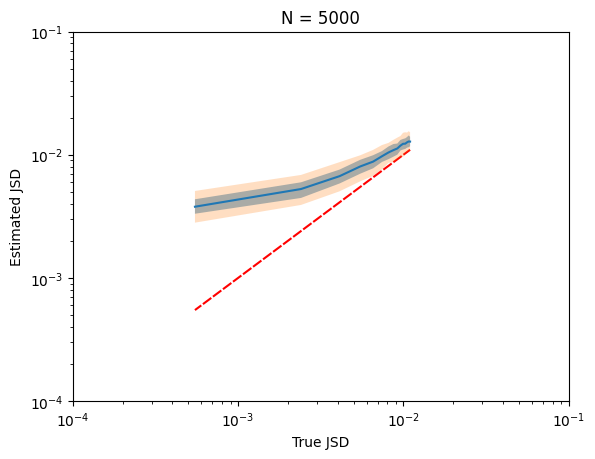

In [10]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(dof_list[-1], true_jsds[0])
# plt.ylim(true_jsds[-1], 1e-1)
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')
plt.xlim(1e-4, 1e-1)
plt.ylim(1e-4, 1e-1)

Text(0.5, 1.0, 'N = 10000')

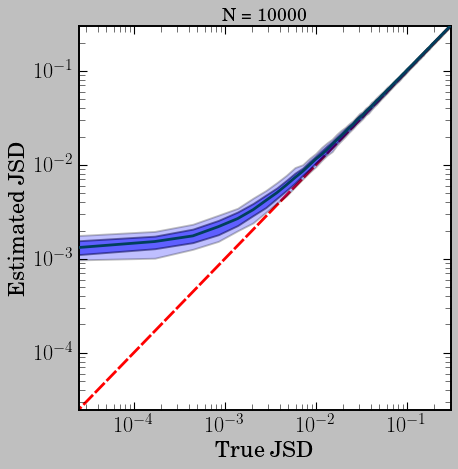

In [45]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 10000')

Text(0.5, 1.0, 'N = 10000')

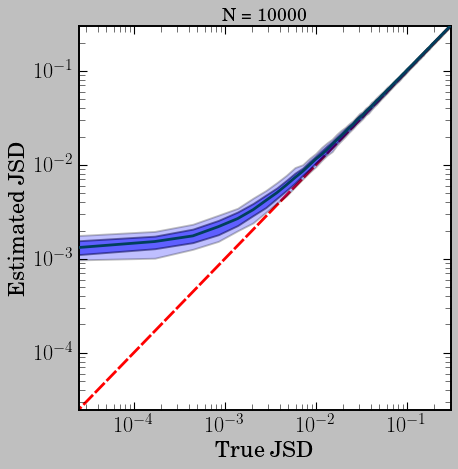

In [48]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 10000')

Text(0.5, 1.0, 'N = 5000')

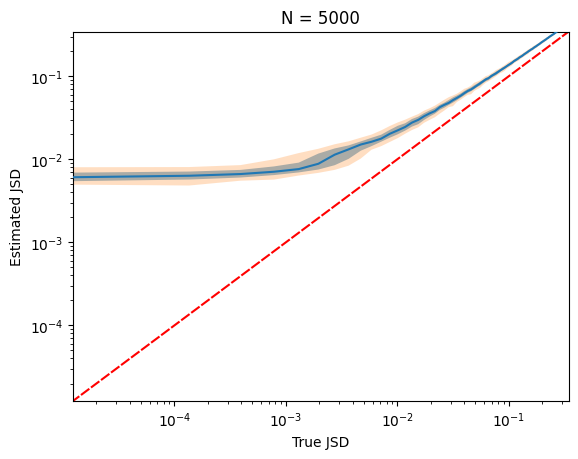

In [16]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')

Text(0.5, 1.0, 'N = 5000')

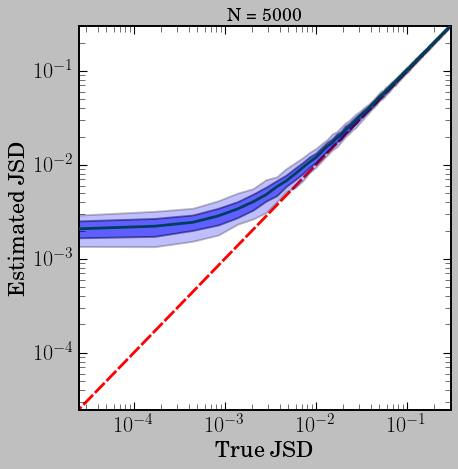

In [52]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')

Text(0.5, 1.0, 'N = 5000')

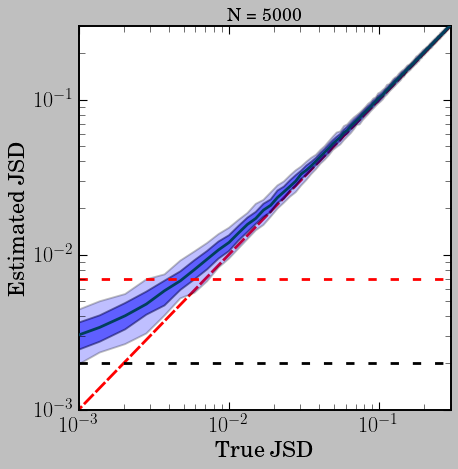

In [61]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3, 3e-1)
plt.ylim(1e-3, 3e-1)
plt.axhline(2e-3, color='k', ls='--')
plt.axhline(7e-3, color='r', ls='--')
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')

In [12]:
np.save('/Users/james/Code/doppel/jsd/jsd_data.npy', estimated_jsds)
np.save('/Users/james/Code/doppel/jsd/jsd_true.npy', true_jsds)